In [1]:
import numpy as np
import h5py
from scipy.ndimage import gaussian_filter1d as gauss_conv
from numba.decorators import jit
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

%matplotlib inline

In [2]:
cd ~/dev/cloudacademyMap/gas_opac/

/Users/lia/dev/cloudacademyMap/gas_opac


In [3]:
import opacity_demo as demo

In [4]:
# Specify which molecules you want to extract from the database (full list available in the readme)
chemical_species = np.array(['H2O', 'CH4', 'NH3', 'HCN', 'CO', 'CO2'])

# At what temperature and pressure do you desire the cross sections?
P = 1.0e-3    # Pressure (bar)
T = 1000.0    # Temperature (K)        

# Specify wavelength grid to extract cross section onto
wl_min = 0.4  # Minimum wavelength of grid (micron)
wl_max = 5.0  # Maximum wavelength of grid (micron)
N_wl = 1000   # Number of wavelength points

wl = np.linspace(wl_min, wl_max, N_wl)  # Uniform grid used here for demonstration purposes   

# Either sample the nearest wavelength points from the high resolution (R~10^6) cross section database or use an averaging prescription 
opacity_treatment = 'Log-avg'           # Options: Opacity-sample / Log-avg
#opacity_treatment = 'Opacity-sample'   # Opacity sampling is faster, but for low-resolution wavelength grids log averaging is recommended
  
# Extract desired cross sections from the database
cross_sections = demo.Extract_opacity(chemical_species, P, T, wl, opacity_treatment)   # Format: np array(N_species, N_wl) / Units: (m^2 / species)

Reading opacity database file
H2O done
CH4 done
NH3 done
HCN done
CO done
CO2 done


In [5]:
# Example: seperate H2O cross section, and print to terminal
H2O_cross_section = cross_sections['H2O']    # Format: np array(N_wl) / Units: (m^2 / molecule)
#print (H2O_cross_section)

In [6]:
# Copy/paste plot function from opacity_demo.py because I'm getting some weird errors

def plot_opacity(chemical_species, sigma_stored, P, T, wl_grid, **kwargs):

    # Max number of species this can plot is 9 (clustered beyond that!)                                                                                                  

    # Optional smoothing of cross sections (can improve clarity)                                                                                                         
    smooth = False
    smooth_factor = 5

    # Specify cross sections to plot, along with colours for each                                                                                                        
    #colours_plot = np.array(['royalblue', 'purple', 'crimson', 'orange', 'black', 'grey', 'green', 'magenta', 'chocolate'])                                             

    # Initialise plot                                                                                                                                                    
    #ax = plt.gca()
    #ax.set_xscale("log")                                                                                                                                                

    ax = plt.subplot(111)
    #xmajorLocator   = MultipleLocator(1.0)
    #xmajorFormatter = FormatStrFormatter('%.1f')
    #xminorLocator   = MultipleLocator(0.2)

    #ax.xaxis.set_major_locator(xmajorLocator)
    #ax.xaxis.set_major_formatter(xmajorFormatter)
    #ax.xaxis.set_minor_locator(xminorLocator)

    # Plot each cross section                                                                                                                                            
    for species in chemical_species:
        #species_idx = np.where(chemical_species == species)[0][0]
        sigma_plt = sigma_stored[species]*1.0e4   # Cross section of species q at given (P,T) pair (cm^2)                                                          

        if (smooth == True):
            sigma_plt = gauss_conv(sigma_plt, sigma=smooth_factor, mode='nearest')

        # Plot cross section                                                                                                                                             
        plt.semilogy(wl_grid, sigma_plt, label = species, **kwargs)

    plt.ylim([1.0e-28, 2.0e-18])
    plt.xlim([min(wl_grid), max(wl_grid)])
    plt.ylabel(r'$\mathrm{Cross \, \, Section \, \, (cm^{2})}$', fontsize = 15)
    plt.xlabel(r'$\mathrm{Wavelength} \; \mathrm{(\mu m)}$', fontsize = 15)

    ax.text(min(wl_grid)*1.05, 6.0e-19, (r'$\mathrm{T = }$' + str(T) + r'$\mathrm{K \, \, P = }$' + str(P*1000) + r'$\mathrm{mbar}$'), fontsize = 14)

    legend = plt.legend(loc='upper right', frameon=False, prop={'size':6}, ncol=2)

    '''for legline in legend.legendHandles:
        legline.set_linewidth(1.0)'''
    return

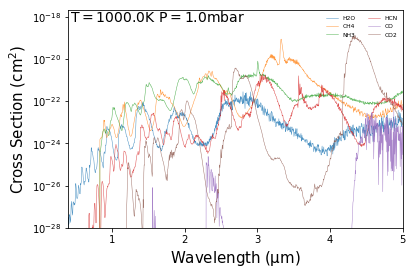

In [7]:
# Plot cross sections
plot_opacity(chemical_species, cross_sections, P, T, wl, lw=0.5, alpha=0.8)

## Grab all the opacities possible

Based on gases present both in Ryan's library and in the static weather output.

In [ ]:
# Grabbed from Readme.txt
RMcD_gas = np.array(['H3+', 'Na', 'K', 'Li', 'Rb', 'Cs', 'H2', 'H2O', 'CH4', 'NH3', 'HCN', 'CO', \
                     'CO2', 'C2H2', 'H2S', 'N2', 'O2', 'O3', 'OH', 'NO', 'SO2', 'PH3', 'TiO', 'VO', \
                     'ALO', 'SiO', 'CaO', 'TiH', 'CrH', 'FeH', 'ScH', 'AlH', 'SiH', 'BeH', 'CaH', \
                     'MgH', 'LiH', 'SiH', 'CH', 'SH', 'NH'])

RMcD_gas_upper = np.array([g.upper() for g in RMcD_gas])

In [ ]:
np.array(RMcD_gas_upper) == 'TIO'

In [ ]:
cd ..

In [ ]:
from maplib import load_out3

In [ ]:
cd ~/Dropbox/Science/cloud-academy/Les_Houches_Cloud_Activity/

In [ ]:
# An example file to work from. I hope all of the reported columns are the same
PHI, THETA = -180, 0

# Get gas information
thermo = load_out3('thermo', PHI, THETA)

# Get wavelengths for later
wavel = load_out3('wavel', PHI, THETA)

In [ ]:
thermo_gas = []
for k in thermo.keys():
    x = k.split('n_')
    if len(x) == 2:
        thermo_gas.append(x[1])
print(thermo_gas)

In [ ]:
# Gases in static_weather model that are also in Ryan's opacity library
gases, gases_missing = [], []
for g in thermo_gas:
    if g in RMcD_gas_upper:
        ig = np.where(RMcD_gas_upper == g)[0]
        gases.append(RMcD_gas[ig][0])
    else:
        gases_missing.append(g)

In [ ]:
print("Gases in both static_weather and Ryan's opacity library: ({} total)".format(len(gases)))
print(gases)
print("\nGases missing opacities: ({} total)".format(len(gases_missing)))
print(gases_missing)

In [ ]:
cd ~/dev/cloudacademyMap/gas_opac

**Takes a few minutes to read in**

In [ ]:
%%time
sw_xsects = demo.Extract_opacity(np.array(gases), P, T, wavel, opacity_treatment)

In [ ]:
plot_opacity(np.array(gases), sw_xsects, P, T, wavel, marker='o', ls=':', alpha=0.5)
plt.semilogx()
plt.xlim(0.2, 330)

In [ ]:
len(thermo['p'])

## To do next

* Load opacities for different temperatures. Interpolate densities in each vertical profile to match the temperatures provided in the code.

* Calculate dtau_dz for each element and vertical profile.

* Save the dtau_dz profiles to a file.

* Add those dtau_dz values to the atmosphere depth calculation.

## Look at densities as a function of temperature

In [ ]:
for g in gases:
    plt.plot(thermo['T'], thermo['n_' + g.upper()])
plt.semilogy()
plt.xlim(500, 3000)

In [ ]:
# Sanity check for pressure, temperature interpolation
# Suggested by Ryan

T0 = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2500, 3000, 3500]
T1 = np.arange(100, 3000, 50)

In [ ]:
test_T0 = demo.Extract_opacity(np.array([gases[0]]), P, T0, wavel, opacity_treatment)